# Rockall Trough glider section - EOF analysis

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct
import src.features.RT_transport as rtt
import src.features.RT_EOF_functions as rt_eof
import src.set_paths as sps
import src.RT_parameters as rtp
import src.features.RT_visualise as rtv

In [4]:
from matplotlib import pyplot as plt
import dask
import datetime
import gsw
import numpy as np
import pandas as pd
import mat73
import xarray as xr
from pathlib import Path
import xeofs as xe
import warnings
warnings.filterwarnings('ignore')
xr.set_options(display_expand_attrs=False)
%matplotlib inline

# Set in- and output path

In [5]:
date_str_start = '2020'
date_str_end = '2023'
fn_version = 'v0'
script_name = f"2.0_Rockall_Trough_glider_EW_EOF_{date_str_start}_{date_str_end}"

# output figures
fig_out_path = (sps.local_fig_dir/f"{script_name}")
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [6]:
# mooring intput data
fn_in_version = 'v1'
fn_base_grid = "Rockall_Trough_mooring_gridded_TSUV"
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"
date_str_start_moor = '201407'
date_str_end_moor = '202207'

RT_mooring_fn = f"{fn_base_grid}_{date_str_start_moor}_{date_str_end_moor}_{fn_in_version}.nc"
file_name_in_stack = f"{fn_base_stack}_{date_str_start_moor}_{date_str_end_moor}_{fn_in_version}.nc"

# transport input data
fn_in_version = 'v0'
fn_base_grid = "Rockall_Trough_transport_3D_TIME_series"
date_str_start_moor = '201407'
date_str_end_moor = '202207'
RT_transp_grid_fn = f"{fn_base_grid}_{date_str_start_moor}_{date_str_end_moor}_{fn_in_version}.nc"

# Load data

In [7]:
# Rockall Trough mooring location
ds_RT_loc=rtd.load_RT_loc()

# Rockall Trough horizontal grid
RT_hor_grid = rtt.create_horizontal_grid('v1')

# stacked RT mooing data
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

# load gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/RT_mooring_fn))

# Extrapolate top and linearly interpolate over gaps
ds_RT = rtf.prep_mooring_data_for_transport_calc(ds_RT,ds_RT_loc)

# Get dz (top/bottom cells are ~10m thick, cells are ~20m thick elsewhere)
dz = rtt.get_dz(ds_RT.depth)
ds_RT['dz']=xr.DataArray(dz,dims='depth')

# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((sps.GEBCO_data_path/sps.GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS = rtd.load_glorys('RTADCP',ds_RT.TIME.min(),ds_RT.TIME.max())


Data is in GLORYS reanlysis and interim period


In [8]:
#Reconstructed Rockall Trough transport section
ds_q_RT = xr.open_dataset((sps.RT_transport_data_path_v0/RT_transp_grid_fn))
ds_q_RT_full = ds_q_RT.sel(lon=slice(ds_RT_loc.lon_RTEB.values,None))
ds_q_RT = ds_q_RT_full.sel(depth=slice(None,1000))


In [12]:
#load glider
ds_glider = matlab_fct.load_glider_mat(sps.glider_data_path,sps.glider_fn)
ds_glider_nan = rt_eof.add_nan_glider_sections(ds_glider)

# Interpolate glider to EB1 depths
ds_glider['depth']=np.abs(ds_glider.depth)
ds_glider = ds_glider.interp(depth=('depth',ds_RT.depth.data)).rename({'time':'TIME'}).sel(depth=slice(None,1000))

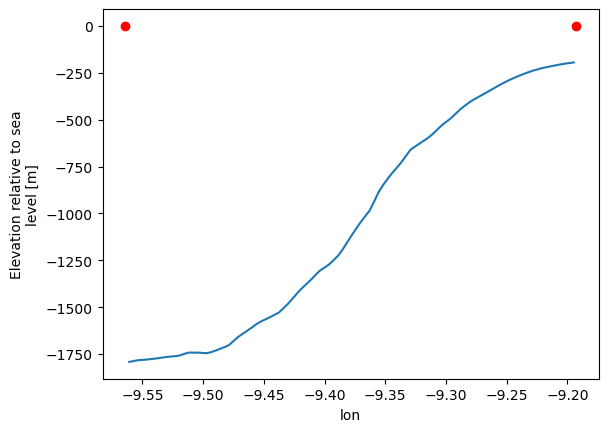

In [13]:
bathy_EW = ds_GEBCO.elevation.interp(
            lon=RT_hor_grid.lon_EW, lat=RT_hor_grid.lat_EW
            ).drop(['lon','lat'])
bathy_EW.coords['lon_EW']=RT_hor_grid.lon_EW
bathy_EW=bathy_EW.rename({'lon_EW':'lon'})
bathy_EW.plot()
plt.plot(ds_RT_loc.lon_RTEB,0,'ro')
plt.plot(ds_RT_loc.lon_RTES,0,'ro')

# Analysis

#### To Do
- [ ] Calc some stats for glider reconstruction
- [ ] Calc transport instead of spatially average velocities
- [ ] Add attributes
- [ ] Repeat using EOFs instead of EOFs -> this notebook
- [ ] Repeat using extended EOFs instead of EOFs

#### Acronyms
- Glider - velocity from glider sections May 2020- Feb 2023
- RT EW full - full data set (Jul 2014- Jul 2022) - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- RT EW 2020-2022 - data from period Jan 2020- Jul 2022 - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- RT EW resampled - data interpolated on Glider TIME stamp (May 20-Jul 23) -velocity section from eastern wedge transport reconstruction (Fraser et al., 2022) 
    !NOTE: RT EW TIME series ends in July 2022 and does not cover full glider TIMEseries!

## Mean velocity section

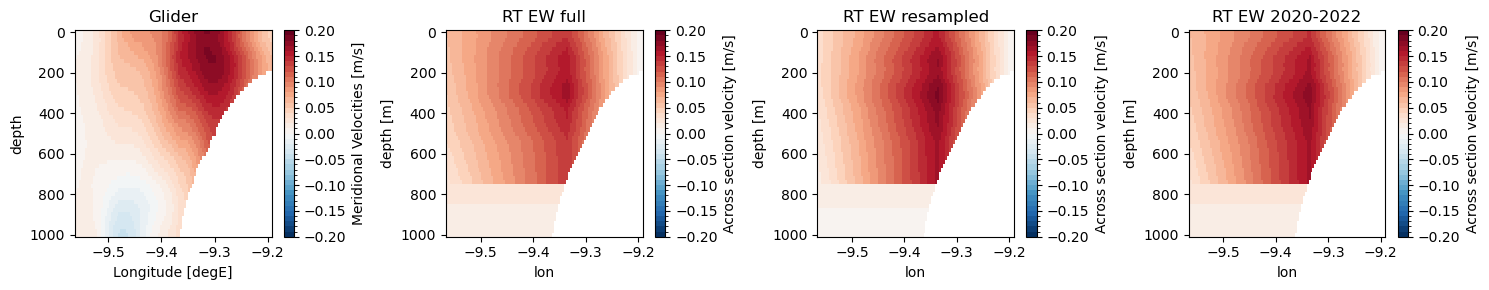

In [14]:
fig,axs = plt.subplots(1,4,figsize=[15,3])
vmin,vmax,levs=-0.2,0.2,41

ax=axs[0]
ds_glider.vcur.mean(['TIME']).plot(x='lon',ax=ax,yincrease=False,
                                   vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('Glider')
ax=axs[1]
ds_q_RT.v.mean(['TIME']).plot(x='lon',ax=ax,yincrease=False,
                              vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW full')
ax=axs[2]
ds_q_RT.v.interp(TIME=ds_glider.TIME.values
                   ).mean(['TIME']).plot(x='lon',ax=ax,yincrease=False,
                                         vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW resampled')
ax=axs[3]
ds_q_RT.v.sel(TIME=slice('2020',None)
                ).mean(['TIME']).plot(x='lon',ax=ax,yincrease=False,
                                      vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW 2020-2022')
plt.tight_layout()

We are missing the undercurrent in ER EW reconstruction.

## Seasonal Cycle - spatially averaged velocity

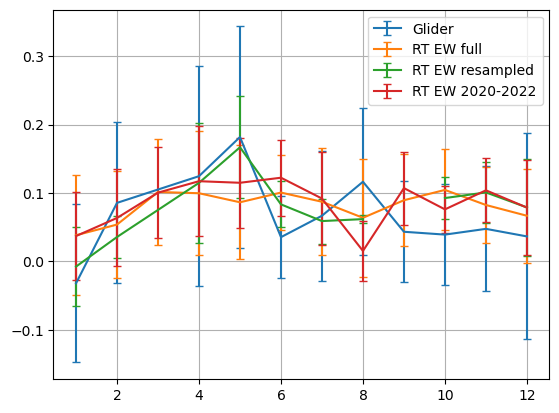

In [15]:
color='C0'
m=ds_glider.vcur.groupby('TIME.month').mean(['TIME','lon','depth'])
d=ds_glider.vcur.groupby('TIME.month').std('TIME').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='Glider')

color='C1'
m = ds_q_RT.v.groupby('TIME.month').mean(['TIME','lon','depth']) 
d=ds_q_RT.v.groupby('TIME.month').std('TIME').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW full')

color='C2'
m = ds_q_RT.v.interp(TIME=ds_glider.TIME.values
                ).groupby('TIME.month').mean(['TIME','lon','depth'])
d=ds_q_RT.v.interp(TIME=ds_glider.TIME.values
                ).groupby('TIME.month').std('TIME').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW resampled')

color='C3'
m = ds_q_RT.v.sel(TIME=slice('2020',None)
                ).groupby('TIME.month').mean(['TIME','lon','depth'])
d=ds_q_RT.v.sel(TIME=slice('2020',None)
                ).groupby('TIME.month').std('TIME').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW 2020-2022')
plt.legend()
plt.grid()

When resampled on the same TIME stamp, the glider and the RT EW reconstruction are quite silimar. However, when compared to the full TIME series it is clear that the seasonal cycle reconstructed from the glider still suffers from aliasing.

August high velocities in glider section dominated by values observed in August 2022 (see figure below). Unfortunatly the moored transport TIME series ends in July 2022!

## TIME series in original resolution 2020-2022 - spatially averaged velocity

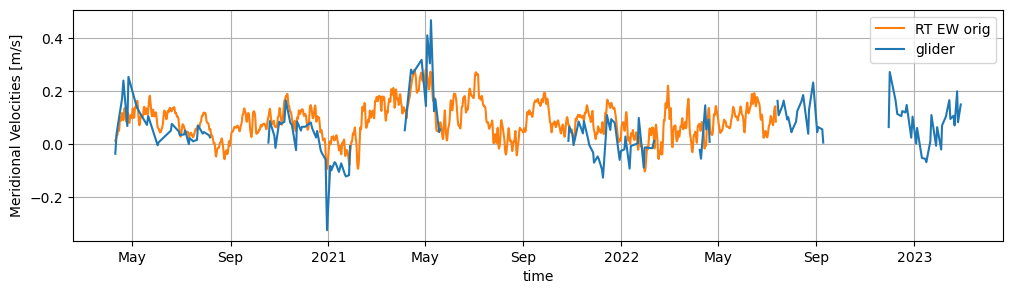

In [16]:
ds_q_RT.v.sel(TIME=slice(ds_glider.TIME.min().values,ds_glider.TIME.max().values)
                ).mean(['lon','depth']).plot.line('-',label='RT EW orig',figsize=[12,3],color='C1')
ds_glider_nan.vcur.mean(['lon','depth']).plot.line('-',label='glider',color='C0')
# ds_q_RT.v.interp(TIME=ds_glider.TIME.values
#                 ).mean(['lon','depth']).plot.line('-',label='RT EW resampled')
plt.legend()
plt.grid()

# EOF

### Idealized dataset
- Barotropic signal varying only in TIME with a period of T=365 days + Travelling wave with a  period of T=73 days
- Amplitude of annual signal is 1.5 higher than travelling wave

#### Snapshots of idealized dataset for different TIME periods

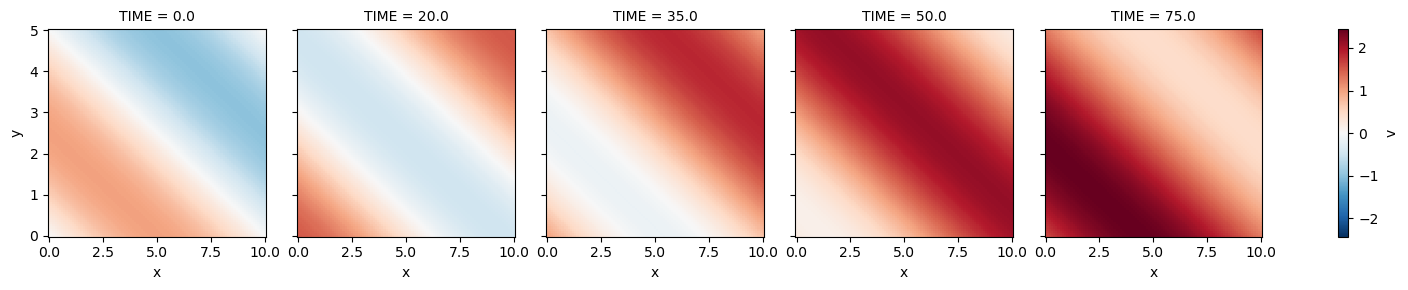

In [17]:
T=73
x = xr.DataArray(np.linspace(0,10,101),dims='x')
y = xr.DataArray(np.linspace(0,5,101),dims='y')
t = xr.DataArray(np.linspace(0,5*365,5*73+1),dims='TIME')
w=2*np.pi/T
k=2*np.pi/20
l=2*np.pi/10

v = np.sin(k*x+l*y+w*t)+1.5*rt_eof.harmonic_cycle(t, T=365, phi=0)
v = v-v.mean('TIME')

v.name='v'
v.coords['x']=x
v.coords['y']=y
v.coords['TIME']=t
v.TIME.attrs = {'units':'days'}

v.sel(TIME=[0,20,35,50,75]).plot(x='x',col='TIME')
plt.show()

#### HEOF analysis of the idealized dataset

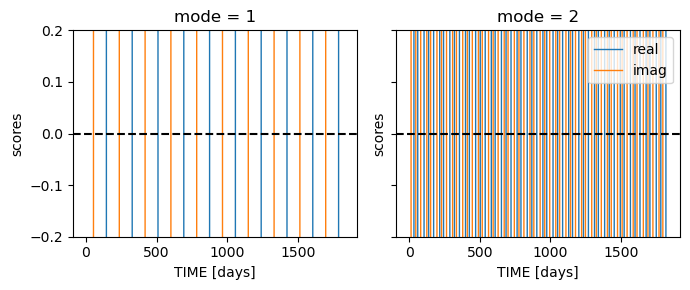

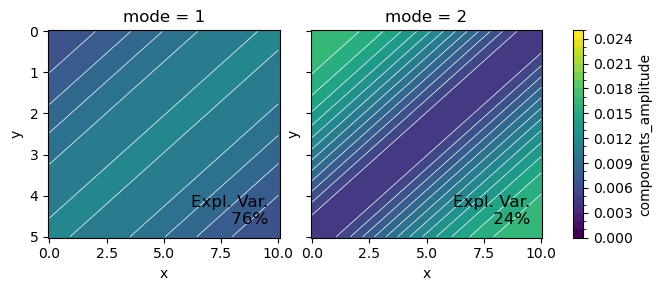

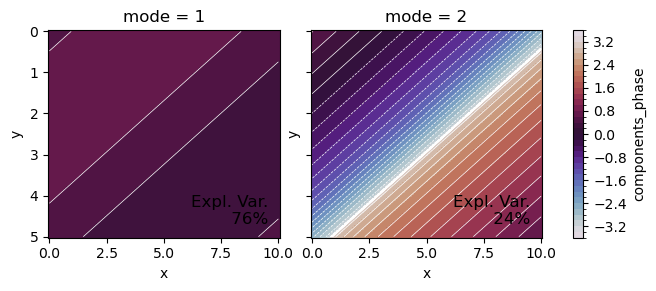

In [18]:
model = rt_eof.HEOF_func(v)

This is a demonstration how to interprete the HEOF/EOF analysis of the observations. The HEOF scores show the temporal evolution of the pattern (components_amplitude and components_phase). A homogenous phase indicates that the signal does not travel spatially. In this case mode 1 shows a the spatially homogenous anual strengthening and weakening, while mode 2 show the semi-annual signal wich is propageting through the domain (as presented by the phase). Mode 3 and 4 are noise and irrelavant (explained variance is closed to zero).

Now I will apply a EOF analysis to the data, which commonly shows a moving pattern as two different modes.

#### Results of the EOF analysis of the idealized dataset

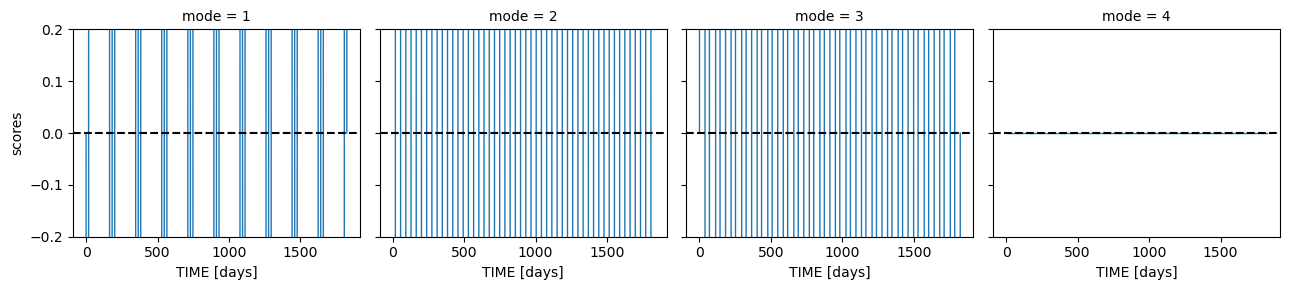

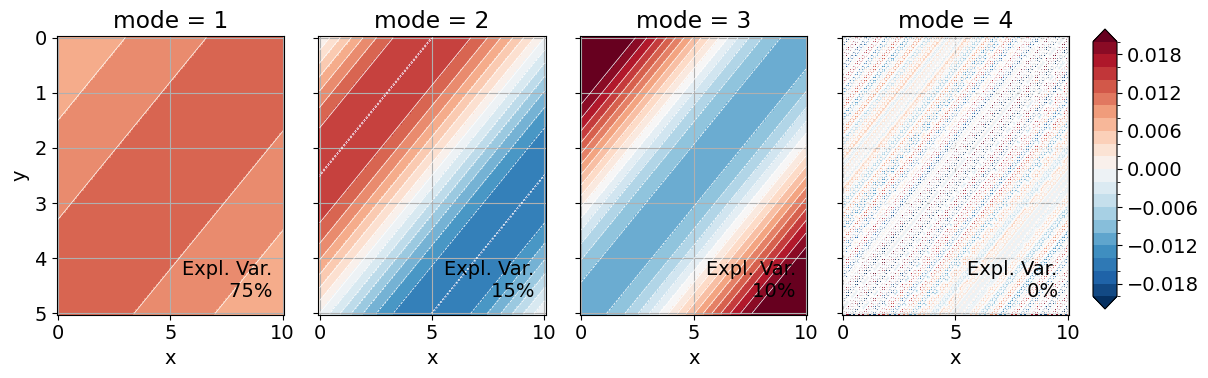

In [19]:
model = rt_eof.EOF_func(v)

The EOF scores show the temporal evolution (principle components) of the EOF pattern (components). EOF analysis is not able to detect patterns moving in space and commonly present a spatially moving pattern as two modes. While the HEOF analysis was able to present the spatially moving pattern of the idealized signal correctly (HEOF mode 2), the eof analysis of the same signal shows the moving pattern as two distingt modes (mode 2 and 3).

This characteristic of EOF and HEOF we will use to identify if there are any moving patterns on the glider observations.

### Glider data
Resampled to 15 days and mean removed

### HEOF analysis

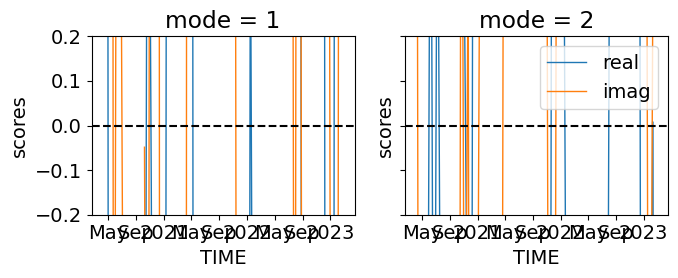

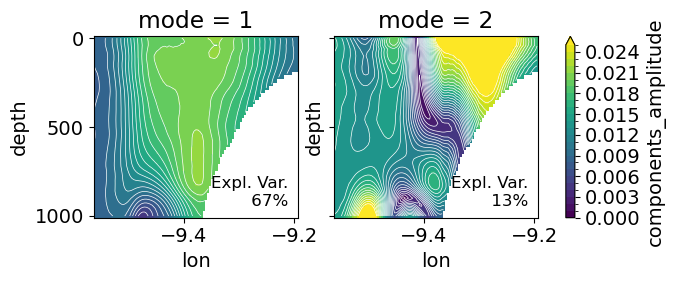

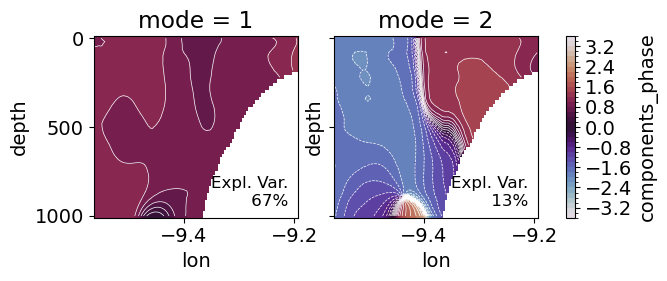

In [20]:
# remove mean
v_anomaly = ds_glider.vcur.resample(TIME="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('TIME',keep_attrs=True)

glider_HEOF = rt_eof.HEOF_func(v_anomaly,dim='lon')

### EOF analysis

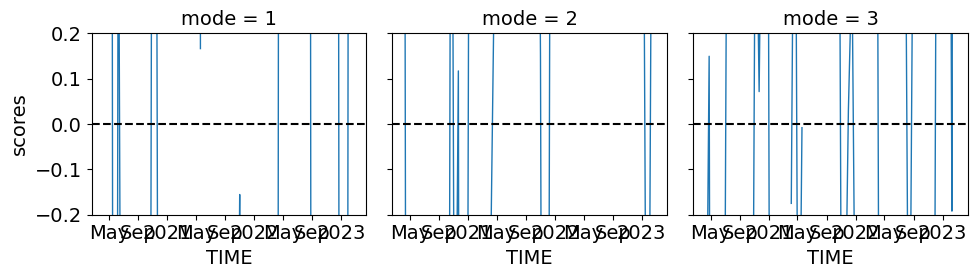

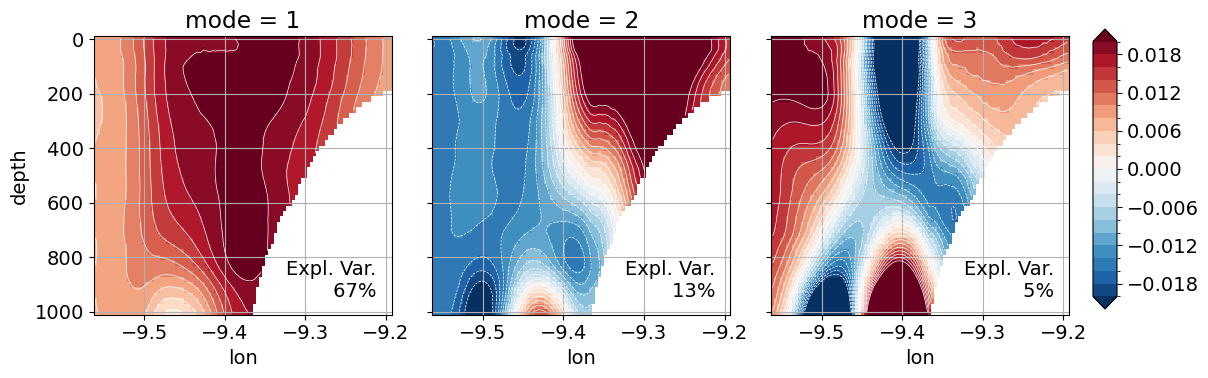

In [21]:
# remove mean
v_anomaly = ds_glider.vcur.resample(TIME="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('TIME',keep_attrs=True)

glider_EOF = rt_eof.EOF_func(v_anomaly,n_modes=3,dim='lon')

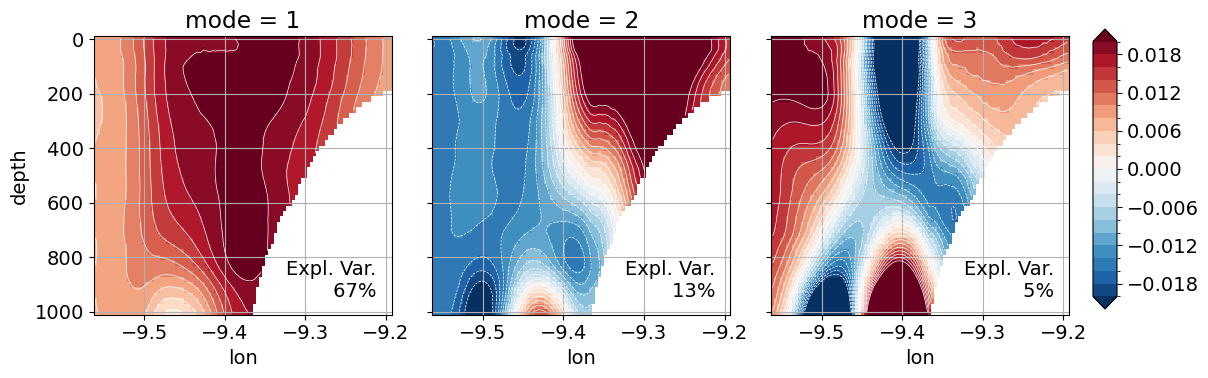

In [22]:
fig = rt_eof.plot_EOF(glider_EOF,dim='lon',EOF=True)
fig.savefig(f'{fig_out_path}RT_glider_EOF_pattern.png',bbox_inches='tight',dpi=300)

The EOF components and their explained variance are similar to the components amplitude and expl. var. of the HEOF analysis. This suggests, that the signals are not travelling in space!

The first EOF seems to display a strengthing/weakening of the velocity field in TIME of same sign in the entire domain explaining 67% of the variance in the glider section. This agrees well with the phase and explained variance of EOF 1 of the reconstructed velocity section using EB1 and GLORYS12v2 output at the ADCP position following Fraser et al. (2022). Here the temporal strengthening/weakening explains up to 83% (see figures below for different TIME periods). However, comparing the amplitudes between glider and reconstructed velocities the later are dominated by velocities at EB1 while the glider section show highest amplitudes between EB1 and the ADCP.

Undercurrent in glider EOF 1 is visible with low amplitudes and a up to ~90 degree phase shift (dark red to dark blue ~90)

The second EOF I would interprete a zonal shift of the slope current with negative velocity to the west of the slope current when the slope current sits shallow in the east onto the shelf and vice versa. Again, EOF2 from the reconstructed veloctiy field (Fraser et al., 2022) agrees well with the glider results. The zero crossing in the reconstructed velocity fields seems to be too far west compared to glider sections.

Again, undercurrent in glider EOF 2 visible with low amplitudes/high east/west of its core in EOF1. Phase shift of ~180 degree between the high/low amplitudes --> zonally migration? --> see if present in ship ladcp?

EOF 3&4 from the glider sections are quite similar and more difficult to interprete. Together they explain up to 9%. I am wondering whether this depicts the vertical migration of the under current or some kind of recirculation between EB1 and the ADCP position? This feature is not visible in the velocity reconstruction from the moored observation (Fraser et al., 2022) which make sense as we do not have any information what happens between EB1 and the ADCP.

### Rockall EW reconstruction
#### Full TIMEseries (2014-2022) 
original resolution, mean removed


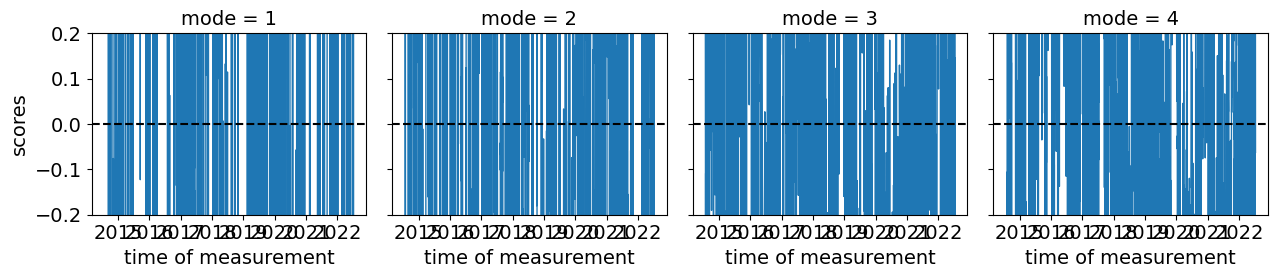

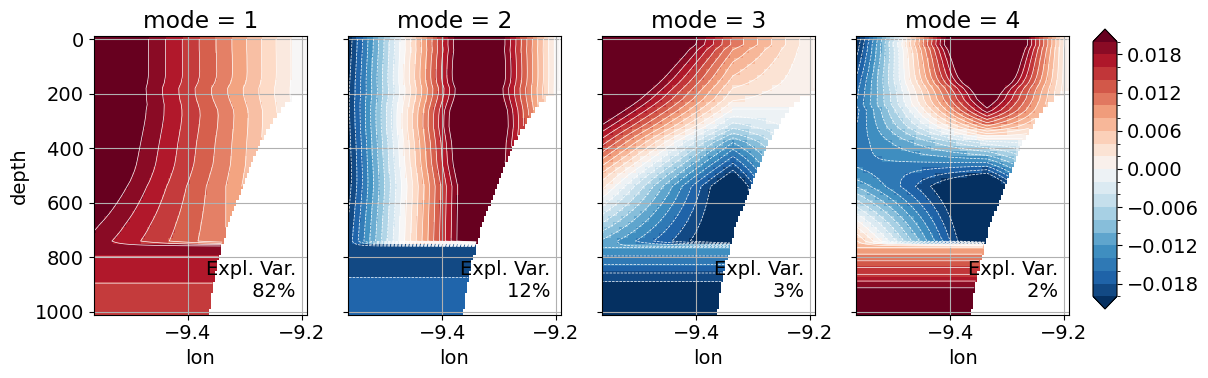

In [23]:
v_anomaly = ds_q_RT.v.rename({'TIME':'TIME'})

# remove mean
v_anomaly = v_anomaly - v_anomaly.mean('TIME',keep_attrs=True)

model = rt_eof.EOF_func(v_anomaly,dim='lon')

#### 2020-2022 
original resolution - mean removed

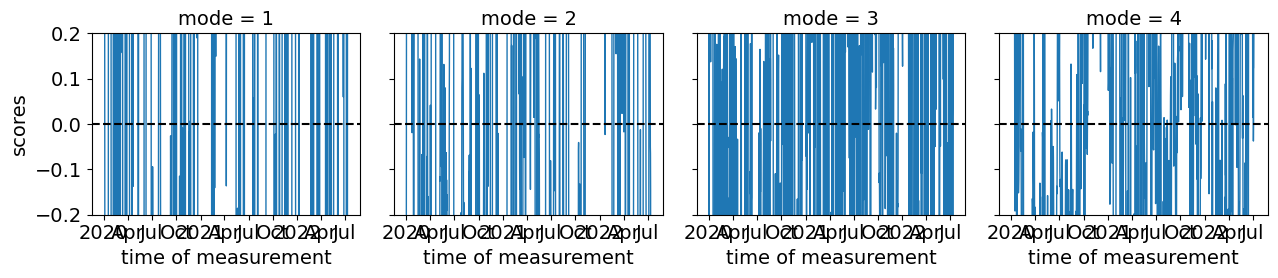

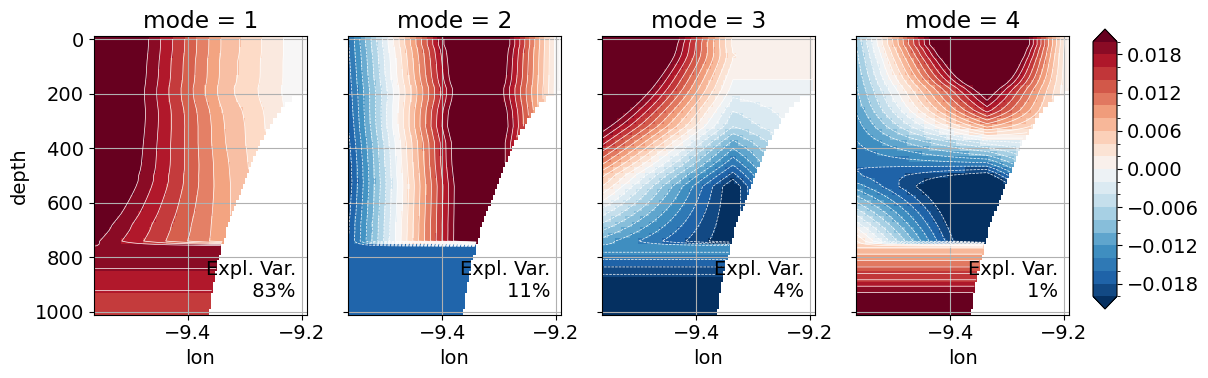

In [24]:
v_anomaly = ds_q_RT.v.sel(TIME=slice('2020','2022')).rename({'TIME':'TIME'})

# remove mean
v_anomaly = v_anomaly - v_anomaly.mean('TIME',keep_attrs=True)

model = rt_eof.EOF_func(v_anomaly,dim='lon')

#### Interp on glider TIME stamps
15D averaged and mean removed

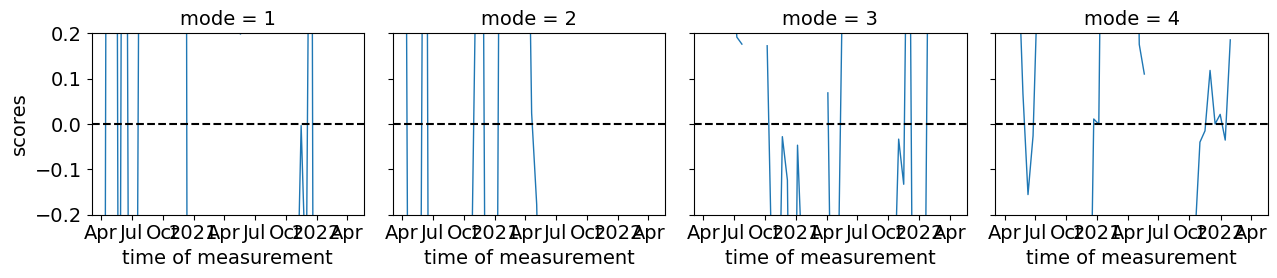

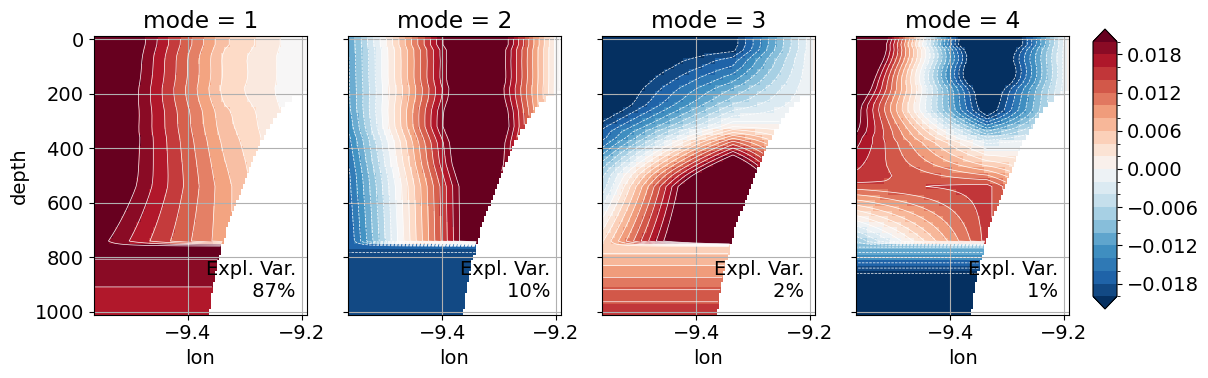

In [25]:
v_anomaly = ds_q_RT.v.interp(TIME=ds_glider.TIME.values).rename({'TIME':'TIME'})
# remove mean
v_anomaly = v_anomaly.resample(TIME="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('TIME',keep_attrs=True)

model = rt_eof.EOF_func(v_anomaly,dim='lon')

# Reconstruction
Idea: Use the spatial pattern from the EOF ($X$) reproduce velocity section ($y$) for the eastern wedge:
$$
X \alpha = y
$$

Therefore we first need to find alpha. We know y at certain locations: the meridional velocities from RTEB1 and GLORYS2v12-ADCP. We can stack them together to get $y_{loc}$, use the EOF at the mooring positions ($X_{loc}$) and find alpha by solving:

$$
X_{loc}^{T}X_{loc} \alpha = X_{loc}^{T}y_{loc}
$$
$$
\alpha = (X_{loc}^{T}X_{loc})^{-1} X_{loc}^{T}y_{loc}
$$



## Error estimation
Recreate glider section using glider obs at point of ERTEB1 and RTADCP for some stats

In [26]:
# Create y from glider data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest')
glider_locs['depth']=np.abs(glider_locs.depth)

# Remove glider sections temporal mean from X
ds_y= (glider_locs - glider_locs.mean('TIME')).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec_glider_moor = rt_eof.rec_v_sec(ds_X,ds_y,glider_EOF,ds_glider.vcur)

In [41]:
v_rec_glider_moor

<xarray.DataArray (mode: 3, lon: 99, depth: 51, TIME: 166)> Size: 20MB
array([[[[ 0.01145661,  0.0282801 ,  0.00450454, ...,  0.11309921,
           0.06856199,  0.0688942 ],
         [ 0.0114591 ,  0.02831218,  0.00449481, ...,  0.11328049,
           0.06866493,  0.06899772],
         [ 0.01152952,  0.028358  ,  0.00457539, ...,  0.11320229,
           0.06865185,  0.06898416],
         ...,
         [ 0.01581809,  0.03207985,  0.00909815, ...,  0.11406691,
           0.07101676,  0.07133788],
         [ 0.01613684,  0.03234425,  0.00943935, ...,  0.11405733,
           0.07115105,  0.07147109],
         [ 0.01658192,  0.03262875,  0.0099508 , ...,  0.11353219,
           0.07105103,  0.0713679 ]],

        [[ 0.01195096,  0.02901545,  0.00489931, ...,  0.11504961,
           0.06987439,  0.07021136],
         [ 0.01197226,  0.0290703 ,  0.00490674, ...,  0.11527365,
           0.0700096 ,  0.07034722],
         [ 0.01235011,  0.02939973,  0.00530459, ...,  0.11535896,
           0.07022309,  0.07055976],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[ 0.02543255,  0.03724278,  0.02914376, ...,  0.07347963,
           0.06716565,  0.05965679],
         [ 0.02635043,  0.03795026,  0.0303534 , ...,  0.07418334,
           0.06833386,  0.05983019],
         [ 0.03007282,  0.04125716,  0.03405042, ...,  0.07717805,
           0.07132429,  0.06236614],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * lon      (lon) float64 792B -9.561 -9.557 -9.553 ... -9.202 -9.199 -9.195
  * depth    (depth) float32 204B 0.0 20.0 40.0 60.0 ... 940.0 960.0 980.0 1e+03
    lat      (lon) float64 792B 57.1 57.1 57.1 57.1 57.1 ... 57.1 57.1 57.1 57.1
    x        (lon, depth) float64 40kB 112.8 112.8 112.8 ... 2.222e+04 2.222e+04
  * TIME     (TIME) datetime64[ns] 1kB 2020-04-10T09:58:32.169342483 ... 2023...
  * mode     (mode) int32 12B 1 2 3
Attributes: (15)

In [35]:
ds_glider['Q']=rt_eof.calc_transport(ds_glider.vcur)
ds_glider['Q_rec']=rt_eof.calc_transport(v_rec_glider_moor)

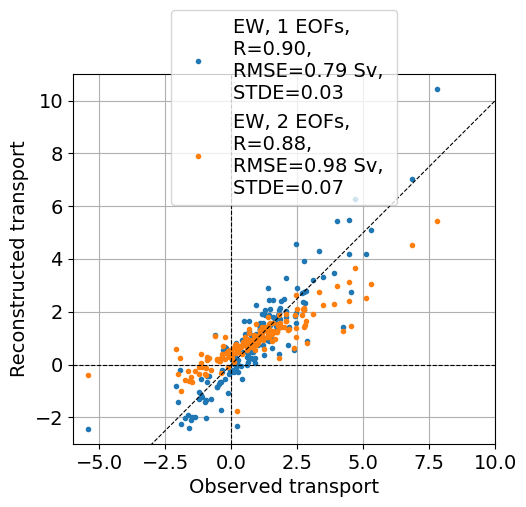

In [36]:
fig,axs = plt.subplots(1,1)
rt_eof.plot_error(ds_glider.Q,ds_glider.Q_rec,2,axs)

## compare to use only EB1 and not RTADCP

In [24]:
# Create y from glider data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[ds_RT_loc.lon_RTEB],method='nearest')
glider_locs['depth']=np.abs(glider_locs.depth)

# Remove glider sections temporal mean from X
ds_y= (glider_locs - glider_locs.mean('TIME')).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().sel(lon=[ds_RT_loc.lon_RTEB],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec_glider_moor_EB1 = rt_eof.rec_v_sec(ds_X,ds_y,glider_EOF,ds_glider.vcur)

In [25]:
ds_glider['Q_rec_EB1']=rt_eof.calc_transport(v_rec_glider_moor_EB1)

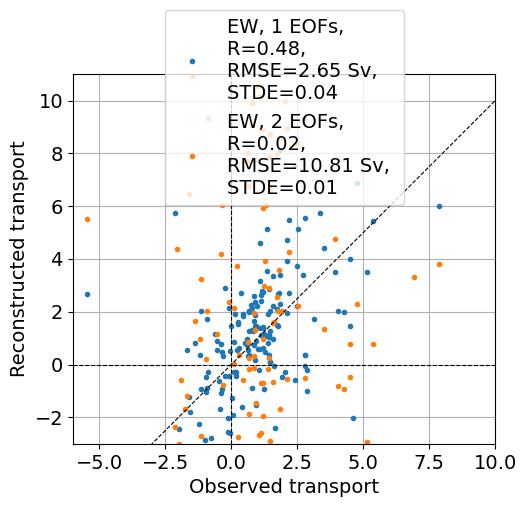

In [26]:
fig,axs = plt.subplots(1,1)
rt_eof.plot_error(ds_glider.Q,ds_glider.Q_rec_EB1,2,axs)

## Recreate sections from moorings

In [27]:
# Create y from moored velocity data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest').mean('TIME').compute()
glider_locs['depth']=np.abs(glider_locs.depth)

# Get RTEB1 meridional velocity
v_RTEB1=(ds_RT.V_EAST/1e2).interp(depth=('depth',glider_locs.depth.data)).rename({'TIME':'TIME'}).drop('PRES')

# Get Glorys data at ADCP station and apply corretions
v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=glider_locs.lon.sel(lon=[ds_RT_loc.lon_RTADCP],method='nearest').data,
                    latitude=ds_RT_loc.lat_RTADCP,
                    TIME=('TIME',v_RTEB1.TIME.data),
                    depth=('depth',glider_locs.depth.data)) + rtp.corr_model

# Duplicate top GLORYS-ADCP values
mask = v_GLO_RTADCP
mask = (mask.notnull()+mask.shift(depth=-1).notnull())
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")
v_GLO_RTADCP = v_GLO_RTADCP.where(mask).rename({'longitude':'lon'})


# combinde both to one matrix (TIME,depth,lon)
ds_y = xr.concat([v_RTEB1,v_GLO_RTADCP.drop_vars(['latitude','lon'])], dim="lon")
ds_y['lon']=glider_locs.lon.data

# Remove glider sections temporal mean from y
ds_y = (ds_y-glider_locs).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec = rt_eof.rec_v_sec(ds_X,ds_y,glider_EOF,ds_glider.vcur)

## Reconstruct without bias correction

In [28]:
# Create y from moored velocity data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest').mean('TIME').compute()
glider_locs['depth']=np.abs(glider_locs.depth)

# Get RTEB1 meridional velocity
v_RTEB1=(ds_RT.V_EAST/1e2).interp(depth=('depth',glider_locs.depth.data)).rename({'TIME':'TIME'}).drop('PRES')

# Get Glorys data at ADCP station and apply corretions
v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=glider_locs.lon.sel(lon=[ds_RT_loc.lon_RTADCP],method='nearest').data,
                    latitude=ds_RT_loc.lat_RTADCP,
                    TIME=('TIME',v_RTEB1.TIME.data),
                    depth=('depth',glider_locs.depth.data))

# Duplicate top GLORYS-ADCP values
mask = v_GLO_RTADCP
mask = (mask.notnull()+mask.shift(depth=-1).notnull())
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")
v_GLO_RTADCP = v_GLO_RTADCP.where(mask).rename({'longitude':'lon'})


# combinde both to one matrix (TIME,depth,lon)
ds_y = xr.concat([v_RTEB1,v_GLO_RTADCP.drop_vars(['latitude','lon'])], dim="lon")
ds_y['lon']=glider_locs.lon.data

# Remove glider sections temporal mean from y
ds_y = (ds_y-glider_locs).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec_bias = rt_eof.rec_v_sec(ds_X,ds_y,glider_EOF,ds_glider.vcur)

## Reconstruct using only EB1

In [29]:
# Create y from moored velocity data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[ds_RT_loc.lon_RTEB],method='nearest').mean('TIME').compute()
glider_locs['depth']=np.abs(glider_locs.depth)

# combinde both to one matrix (TIME,depth,lon)
ds_y = v_RTEB1
ds_y=ds_y.expand_dims(dim={"lon": glider_locs.lon.data})

# Remove glider sections temporal mean from y
ds_y = (ds_y-glider_locs).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().sel(lon=[ds_RT_loc.lon_RTEB],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec_EB1 = rt_eof.rec_v_sec(ds_X,ds_y,glider_EOF,ds_glider.vcur)

## Mean section of glider, RT EW full and EOF-reconstructions
- Glider - velocity from glider sections May 2020- Feb 2023
- RT EW full - full data set (Jul 2014- Jul 2022) - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- EOF [X] full - EOF reconstruction averaging over [X] modes for the full mooring TIME period (Jul 2014- Jul 2022)
- EOF [X] resampled - data interpolated on Glider TIME stamp (May 20-Jul 23) using EOF reconstruction averaged over [X] modes 
    !NOTE: mooring TIME series ends in July 2022 and does not cover full glider TIMEseries!

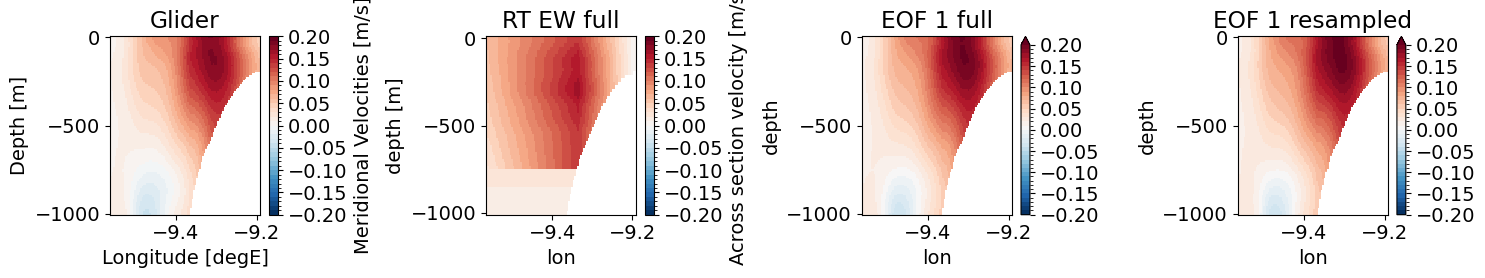

In [30]:
rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec)

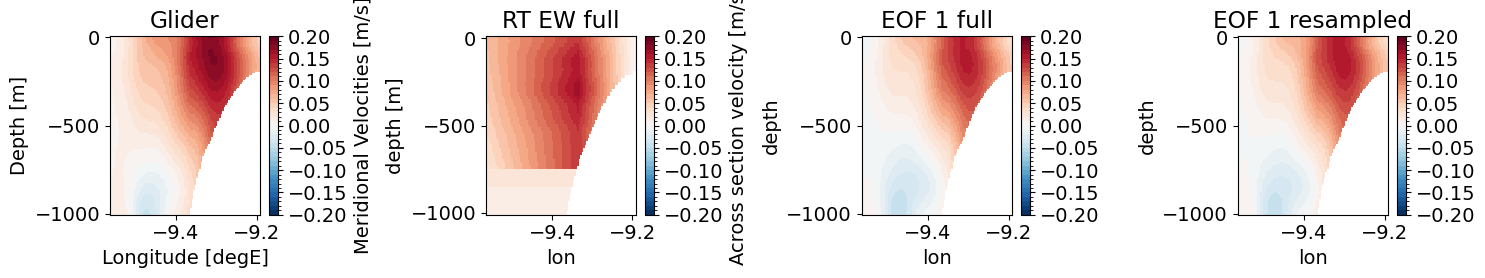

In [31]:
rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec_bias)

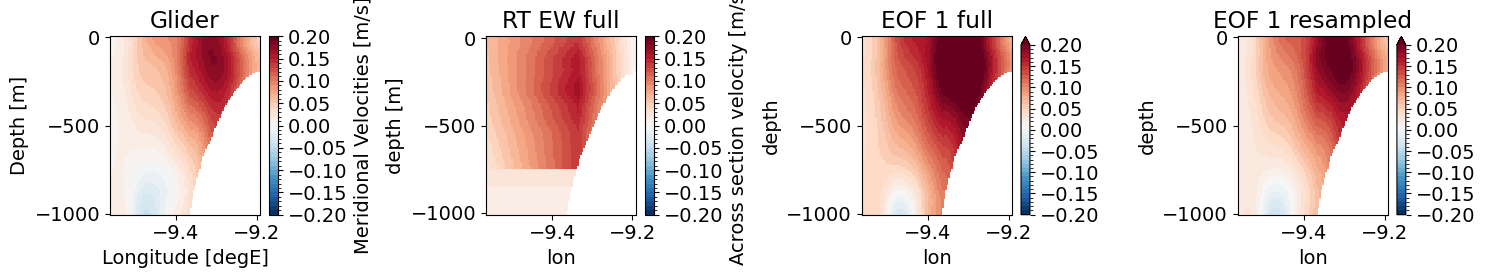

In [32]:
rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec_EB1)

## Seasonal Cycle

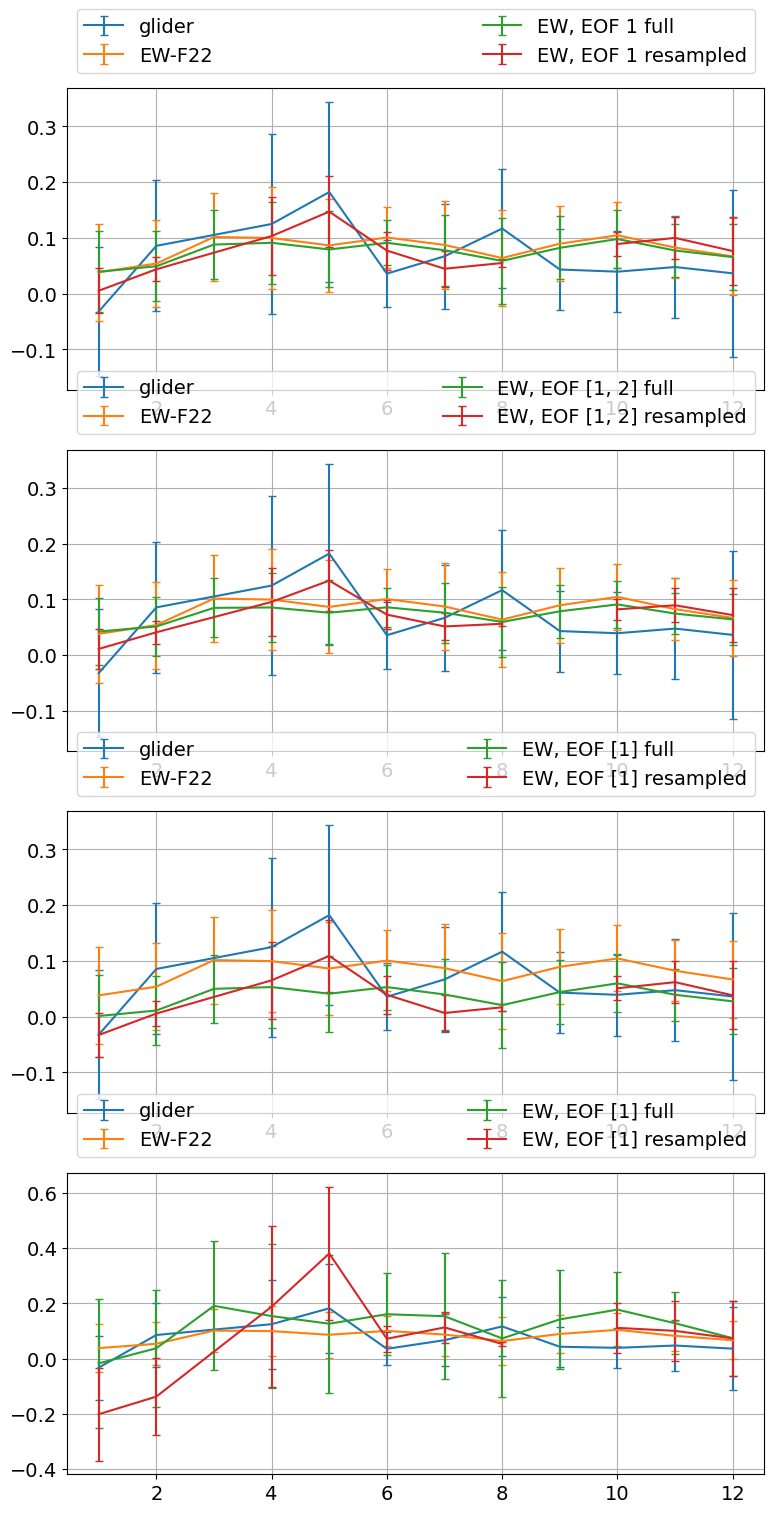

In [33]:
fig,axs = plt.subplots(4,1,figsize=[9,18])
ax=axs[0]
rt_eof.plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=ax,mode_no=1,mean=False)
ax=axs[1]
rt_eof.plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=ax,mode_no=[1,2],mean=True)
ax=axs[2]
rt_eof.plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec_bias,ax=ax,mode_no=[1],mean=True)
ax=axs[3]
rt_eof.plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec_EB1,ax=ax,mode_no=[1],mean=True)

## TIME series in original resolution 2020-2022 - spatially averaged velocity

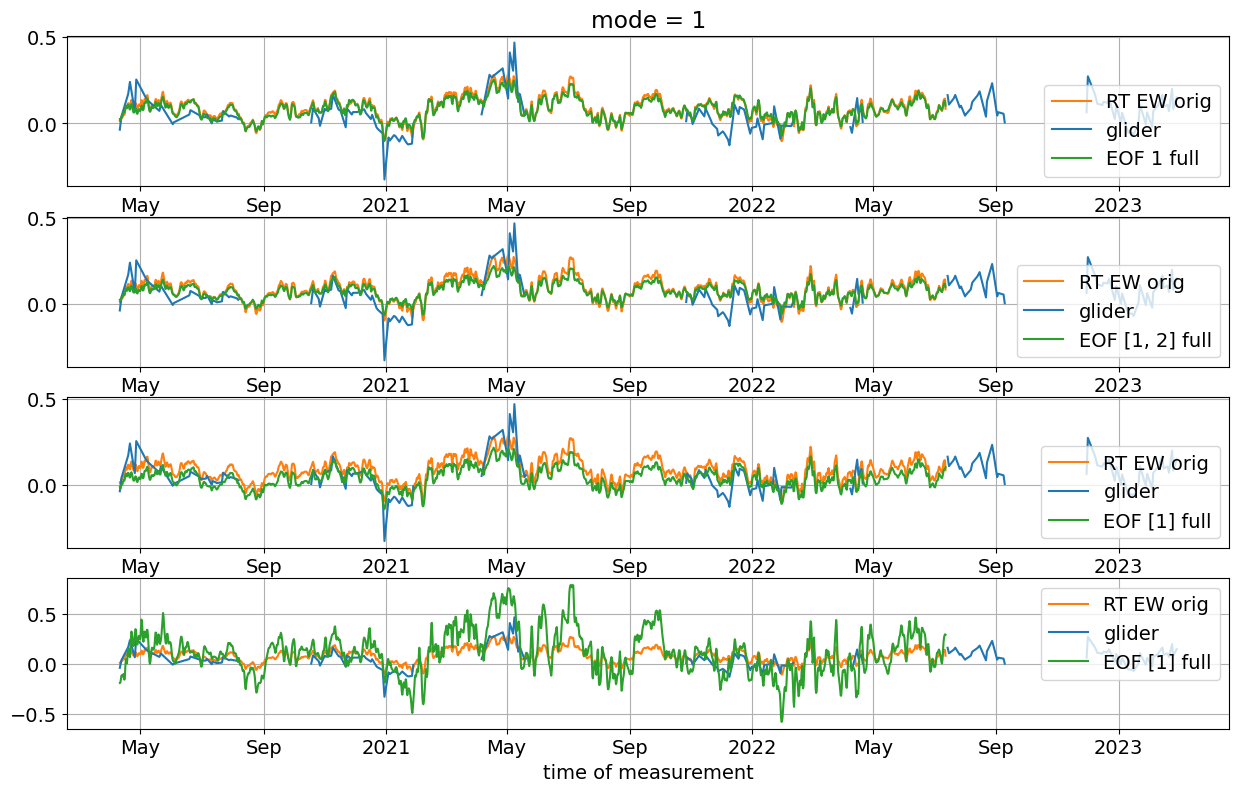

In [34]:
fig,axs = plt.subplots(4,1,figsize=[15,9])
ax=axs[0]
rt_eof.plot_longterm(ds_glider_nan,ds_q_RT,v_rec,ax=ax,mode_no=1,mean=False)
ax=axs[1]
rt_eof.plot_longterm(ds_glider_nan,ds_q_RT,v_rec,ax=ax,mode_no=[1,2],mean=True)
ax=axs[2]
rt_eof.plot_longterm(ds_glider_nan,ds_q_RT,v_rec_bias,ax=ax,mode_no=[1],mean=True)
ax=axs[3]
rt_eof.plot_longterm(ds_glider_nan,ds_q_RT,v_rec_EB1,ax=ax,mode_no=[1],mean=True)

EOF mode 1 seems to best to recontruct velocity fields. No additional values gained for variability. Only better representation of slope current structure.

## Reconstructed transport

In [35]:
Q_rec = rt_eof.calc_transport(v_rec)
Q_rec_bias = rt_eof.calc_transport(v_rec_bias)
Q_rec_EB1 = rt_eof.calc_transport(v_rec_EB1)
Q_moor = (ds_q_RT.q.sum(['lon','depth'])*1e-6)
Q_glider_nan = rt_eof.calc_transport(ds_glider_nan.vcur)
Q_glider_nan = Q_glider_nan.where(ds_glider_nan.vcur.isel(depth=0,lon=0).notnull())

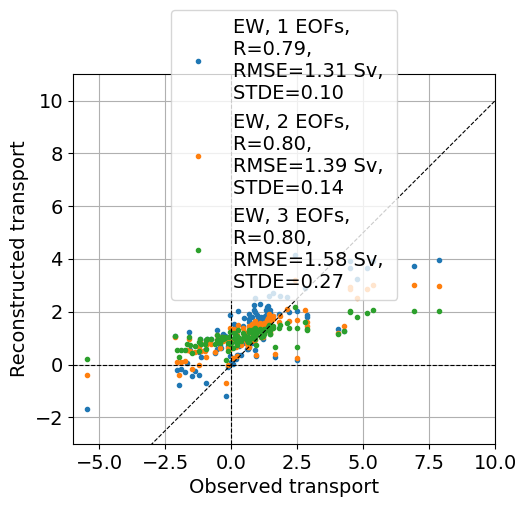

In [36]:
fig,axs = plt.subplots(1,1)
Q_EW_resampled=Q_rec.interp_like(ds_glider.TIME)
Q_EW_resampled=Q_EW_resampled.where(Q_EW_resampled.notnull(),drop=True)
Q_obs = ds_glider.Q.where(Q_EW_resampled.isel(mode=0).notnull(),drop=True)
rt_eof.plot_error(Q_obs,Q_EW_resampled,3,axs)

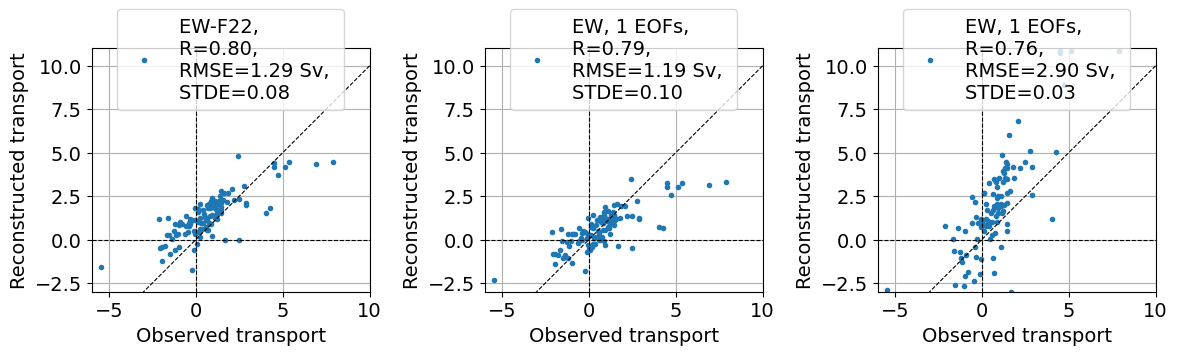

In [37]:
fig,axs = plt.subplots(1,3,figsize=[12,4])
ax = axs[0]
Q_moor_resampled=Q_moor.rename({'TIME':'TIME'}).interp_like(ds_glider.TIME)
Q_moor_resampled=Q_moor_resampled.where(Q_moor_resampled.notnull(),drop=True)
Q_obs = ds_glider.Q.where(Q_moor_resampled.notnull(),drop=True)
rt_eof.plot_error(Q_obs,Q_moor_resampled,0,ax)

ax = axs[1]
Q_EW_resampled_bias=Q_rec_bias.interp_like(ds_glider.TIME)
Q_EW_resampled_bias=Q_EW_resampled_bias.where(Q_EW_resampled_bias.notnull(),drop=True)
Q_obs = ds_glider.Q.where(Q_EW_resampled_bias.isel(mode=0).notnull(),drop=True)
rt_eof.plot_error(Q_obs,Q_EW_resampled_bias,1,ax)

ax = axs[2]
Q_EW_resampled_EB1=Q_rec_EB1.interp_like(ds_glider.TIME)
Q_EW_resampled_EB1=Q_EW_resampled_EB1.where(Q_EW_resampled_EB1.notnull(),drop=True)
Q_obs = ds_glider.Q.where(Q_EW_resampled_EB1.isel(mode=0).notnull(),drop=True)
rt_eof.plot_error(Q_obs,Q_EW_resampled_EB1,1,ax)
plt.tight_layout()

In [48]:
Q_moor

<xarray.DataArray 'q' (TIME: 5827)> Size: 47kB
array([-0.60821723, -0.63600764, -0.64110083, ...,  2.43613567,
        2.4522416 ,  1.45002046])
Coordinates:
  * TIME     (TIME) datetime64[ns] 47kB 2014-07-21T12:00:00 ... 2022-07-12T12...
Attributes: (4)

In [52]:
TIME='TIME'

print(f'{pd.to_dateTIME(Q_glider_nan.TIME.min().values):%b %Y}'+
       f' to {pd.to_dateTIME(Q_glider_nan.TIME.max().values):%b %Y}'+
       f' glider std error - upper 1000m')
print(f'glider  {Q_glider_nan.mean(TIME).values:2.1f}$\pm$'+
    f'{(rtf.std_error(Q_glider_nan,dim=TIME)).values:2.1f}$\,$Sv'+
       f', STD {Q_glider_nan.std(TIME).values:2.1f}$\,$Sv')

print(f'{pd.to_dateTIME(Q_moor.TIME.min().values):%b %Y}'+
       f' to {pd.to_dateTIME(Q_moor.TIME.max().values):%b %Y}'+
       f' moor std error - upper 1000m')

TIME='TIME'
print(f'EW      {Q_moor.mean(TIME).values:2.1f}$\pm$'+
    f'{(rtf.std_error(Q_moor,dim=TIME)).values:2.1f}$\,$Sv'+
       f', STD {Q_moor.std(TIME).values:2.1f}$\,$Sv')
TIME='TIME'
print(f'EW w/o bias correction {Q_rec_bias.sel(mode=1).mean(TIME).values:2.1f}$\pm$'+
      f'{(rtf.std_error(Q_rec_bias.sel(mode=1),dim=TIME)).values:2.1f}$\,$Sv'+
       f', STD {Q_rec_bias.sel(mode=1).std(TIME).values:2.1f}$\,$Sv')
print(f'EW EB1 only {Q_rec_EB1.sel(mode=1).mean(TIME).values:2.1f}$\pm$'+
    f'{(rtf.std_error(Q_rec_EB1.sel(mode=1),dim=TIME)).values:2.1f}$\,$Sv'+
       f', STD {Q_rec_EB1.sel(mode=1).std(TIME).values:2.1f}$\,$Sv')

Apr 2020 to Feb 2023 glider std error - upper 1000m
glider  1.0$\pm$0.3$\,$Sv, STD 1.7$\,$Sv
Jul 2014 to Jul 2022 moor std error - upper 1000m
EW      1.4$\pm$0.2$\,$Sv, STD 1.2$\,$Sv
EW w/o bias correction 0.6$\pm$0.2$\,$Sv, STD 1.1$\,$Sv
EW EB1 only 2.0$\pm$0.5$\,$Sv, STD 3.5$\,$Sv


In [53]:
print(f'{pd.to_dateTIME(Q_obs.TIME.min().values):%b %Y}'+
       f' to {pd.to_dateTIME(Q_obs.TIME.max().values):%b %Y}'+
       f' glider/moor std error - upper 1000m')
print(f'glider  {Q_obs.mean(TIME).values:2.1f}$\pm$'+
    f'{(rtf.std_error(Q_obs,dim=TIME)).values:2.1f}$\,$Sv'+
       f', STD {Q_obs.std(TIME).values:2.1f}$\,$Sv')
print(f'EW      {Q_moor_resampled.mean(TIME).values:2.1f}$\pm$'+
    f'{(rtf.std_error(Q_moor_resampled,dim=TIME)).values:2.1f}$\,$Sv'+
       f', STD {Q_moor_resampled.std(TIME).values:2.1f}$\,$Sv')
print(f'EW w/o bias correction {Q_EW_resampled_bias.sel(mode=1).mean(TIME).values:2.1f}$\pm$'+
      f'{(rtf.std_error(Q_EW_resampled_bias.sel(mode=1),dim=TIME)).values:2.1f}$\,$Sv'+
       f', STD {Q_EW_resampled_bias.sel(mode=1).std(TIME).values:2.1f}$\,$Sv')
print(f'EW EB1 only {Q_EW_resampled_EB1.sel(mode=1).mean(TIME).values:2.1f}$\pm$'+
    f'{(rtf.std_error(Q_EW_resampled_EB1.sel(mode=1),dim=TIME)).values:2.1f}$\,$Sv'+
       f', STD {Q_EW_resampled_EB1.sel(mode=1).std(TIME).values:2.1f}$\,$Sv')

Apr 2020 to Apr 2022 glider/moor std error - upper 1000m
glider  0.7$\pm$0.4$\,$Sv, STD 1.8$\,$Sv
EW      1.4$\pm$0.3$\,$Sv, STD 1.2$\,$Sv
EW w/o bias correction 0.7$\pm$0.3$\,$Sv, STD 1.1$\,$Sv
EW EB1 only 1.5$\pm$0.9$\,$Sv, STD 3.9$\,$Sv


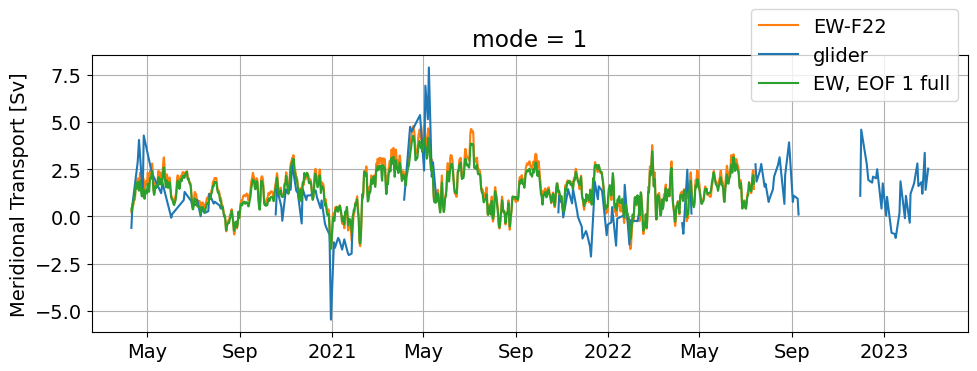

In [40]:
fig,axs = plt.subplots(1,1,figsize=[10,4])
ax=axs
rt_eof.plot_transport(Q_glider_nan,Q_rec,Q_moor,ax=ax,mode_no=1,mean=False)
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.2))
ax.set_xlabel('');
plt.tight_layout()
fig.savefig('Glider_eof.png',bbox_inches='tight',dpi=300)

<xarray.DataArray 'Q' ()> Size: 8B
array(0.68746058)
Coordinates:
    mode     int32 4B 1
Attributes: (2)

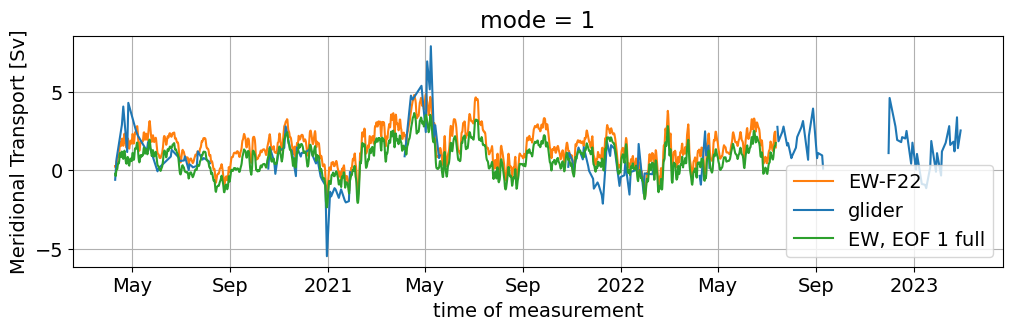

In [41]:
fig,axs = plt.subplots(1,1,figsize=[12,3])
ax=axs
rt_eof.plot_transport(Q_glider_nan,Q_rec_bias,Q_moor,ax=ax,mode_no=1,mean=False)

t_EW = Q_rec_bias.sel(mode=1,TIME=slice(ds_glider.TIME.min().values,ds_glider.TIME.max().values)
        ).interp_like(Q_glider_nan)
t_EW.mean('TIME')

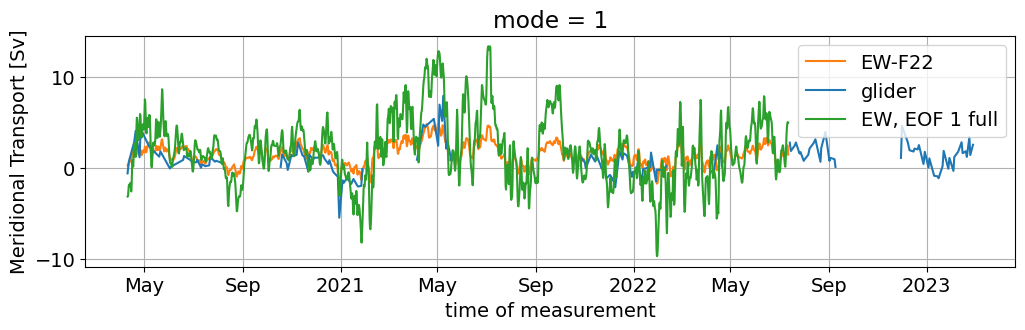

In [42]:
fig,axs = plt.subplots(1,1,figsize=[12,3])
ax=axs
rt_eof.plot_transport(Q_glider_nan,Q_rec_EB1,Q_moor,ax=ax,mode_no=1,mean=False)

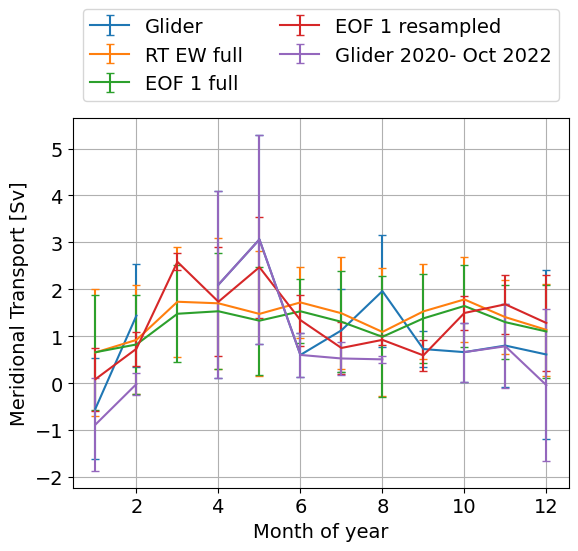

In [43]:
fig,axs = plt.subplots(1,1)
ax=axs
rt_eof.plot_seasonal_cycle_Q(Q_glider_nan,Q_rec,Q_moor,ax=ax,mode_no=1,mean=False)

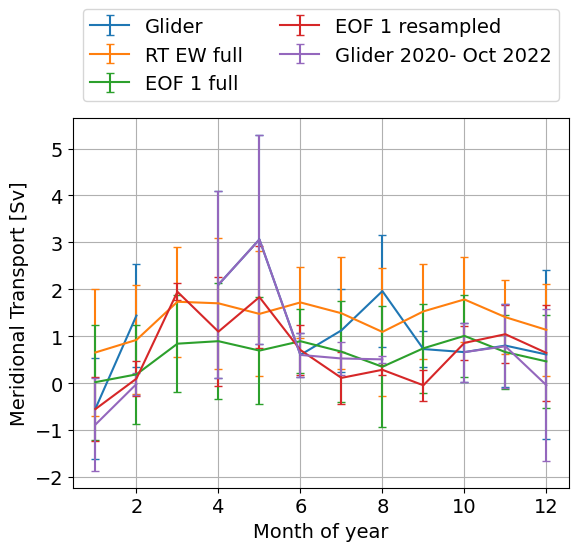

In [44]:
fig,axs = plt.subplots(1,1)
ax=axs
rt_eof.plot_seasonal_cycle_Q(Q_glider_nan,Q_rec_bias,Q_moor,ax=ax,mode_no=1,mean=False)

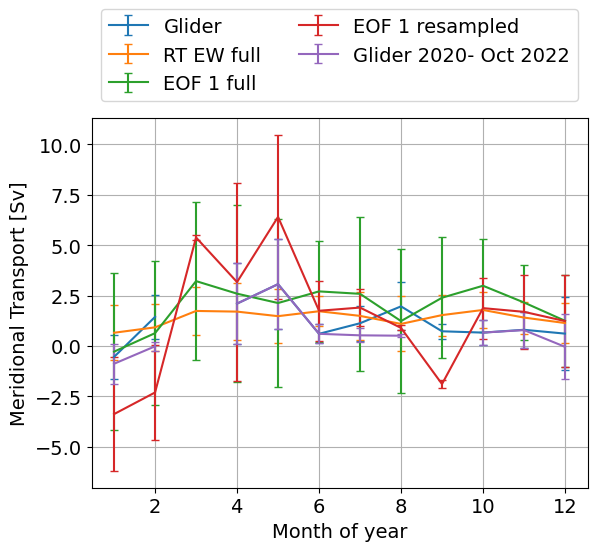

In [45]:
fig,axs = plt.subplots(1,1)
ax=axs
rt_eof.plot_seasonal_cycle_Q(Q_glider_nan,Q_rec_EB1,Q_moor,ax=ax,mode_no=1,mean=False)